# Poisson Equation in 2D

In [1]:
import jax
import anon
import anabel
import anabel.backend as anp
from interpolate import lagrange_t6

Source term, $f$:

In [2]:
f=lambda x: 4.0

The analytic solution, $u$:

In [3]:
u = lambda x: 1-x[0]**2 - x[1]**2

In [4]:
def triangle(interp,xyz=None):
    jacn_interp = diff.jacx(interp)
    
    def transf(xi, xyz=xyz):
        return interp(xi)@xyz
    def jacn_transf(xi,xyz): 
        return jacn_interp(xi)@xyz

In [5]:
import anon.diff as diff
from anabel.template import template

@template(6)
def poisson(transf, test, trial, f=lambda x: 0.0, ndim=2, quad_point=None, thickness=1.0, **kwds):
    """
    Parameters
    ----------
    test, trial : Callable
        test and trial interpolants over the reference element.
    thickness : float
    """
    state = {}
    
    det = anp.linalg.det
    slv = anp.linalg.solve
    
    jacn_test = diff.jacx(test)
    jacn_trial = diff.jacx(trial)
    
    def transf(xi, xyz):
        return test(xi)@xyz
    def jacn_transf(xi,xyz): return jacn_test(xi)@xyz
    
    jacx_test = lambda xi,xyz: slv(jacn_transf(xi,xyz), jacn_test(xi))
    dvol = lambda xi, xyz: 0.5*thickness*abs(det(jacn_transf(xi,xyz)))
    
    def jacx(_,__,___,xyz,xi=quad_point,**kwds):
        return (jacx_test(xi,xyz).T@jacx_test(xi,xyz))*dvol(xi,xyz)
    
    def main(_,__,___,xyz=None,xi=quad_point,**kwds):
        p = (test(xi)[:,None]*f(transf(xi,xyz)))*dvol(xi,xyz)
#         p = (jacx_test(xi,xyz).T@jacx_test(xi,xyz)@u + test(xi)[:,None]*f(transf(xi,xyz)))*dvol(xi,xyz)
        return _,p,___
    return locals()

In [6]:
model =  anabel.MeshGroupModel.read("circle_iso/mesh1", "m228", cell="triangle6")
xi = model.param("xi")
elem = poisson(*[lagrange_t6()]*3,f=f,quad_point=xi)

In [7]:
U = model.compose(elem=elem)
quad = anon.quad.simplex.Simplex.load("gauss02.m")

In [8]:
U_h = U(quad.points, quad.weights)

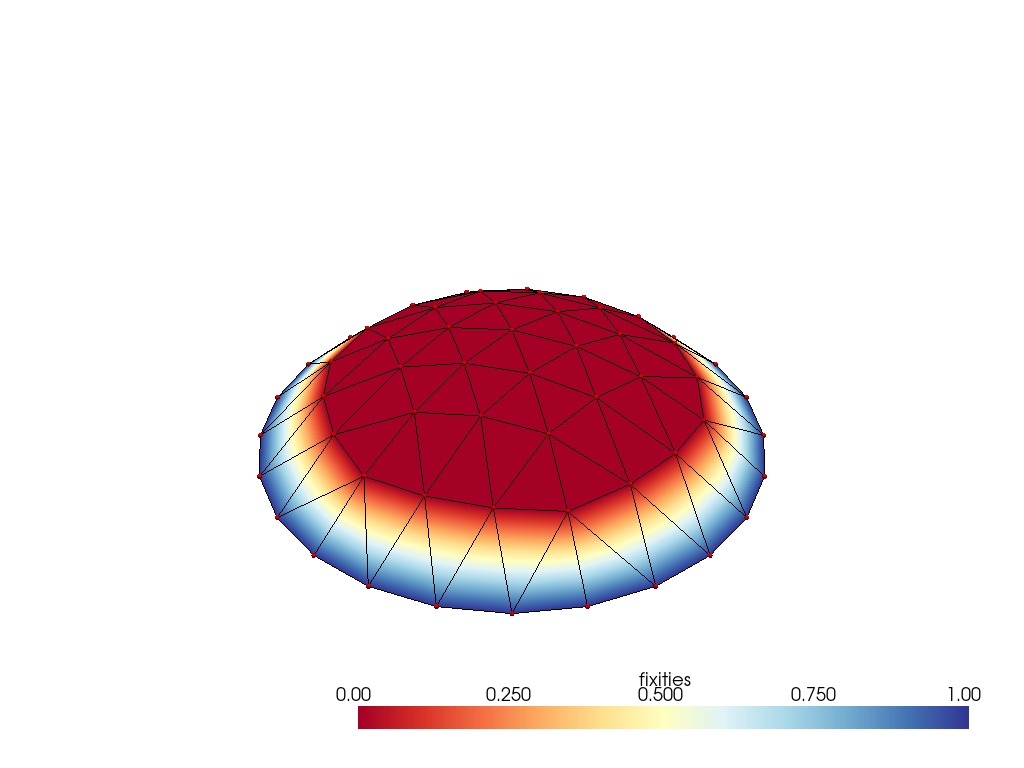

In [9]:
model.plot(U_h,render_points_as_spheres=True)

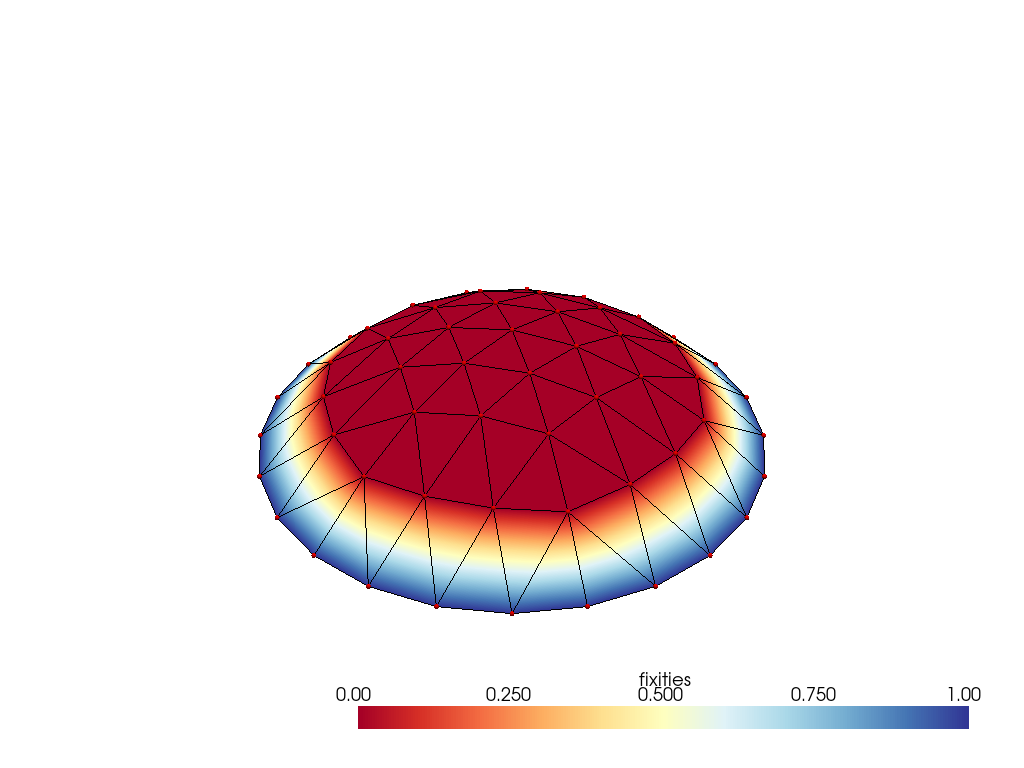

In [10]:
model.plot(func=u)

## Error Analysis

In [22]:
@template(1)
def H1(transf,test,trial,u,quad_point=None, thickness=1.0):
    state = None
    det = anp.linalg.det
    slv = anp.linalg.solve
    du = diff.jacfwd(u)
    jacn_test = diff.jacx(test)
    jacn_trial = diff.jacx(trial)
    
    def transf(xi, xyz):
        return test(xi)@xyz
    def jacn_transf(xi,xyz): return jacn_test(xi)@xyz
    
    jacx_test = lambda xi,xyz: slv(jacn_transf(xi,xyz), jacn_test(xi))
    dvol = lambda xi, xyz: 0.5*thickness*abs(det(jacn_transf(xi,xyz)))
    
    def main(U,__,___,xyz=None,xi=quad_point):
#         analytic = anp.array([[] for ])
        q = (du(transf(xi,xyz)) - jacx_test(xi,xyz)@U)**2 * dvol(xi,xyz)
        return _,q,___
    return locals()

In [23]:
model.assemble_integral(elem=H1(*[lagrange_t6()]*3,u=u))(U_h,points=quad.points,weights=quad.weights)

[array([ 5, 44, 45,  8, 49,  7]), array([ 0,  4,  5,  9, 10, 11]), array([ 5, 45, 46,  7, 50, 12]), array([44,  5,  4,  8, 10, 13]), array([ 4, 42, 43, 15, 51, 14]), array([ 3, 41, 42, 16, 52, 17]), array([ 0,  3,  4, 18, 19,  9]), array([ 3, 40, 41, 20, 53, 16]), array([ 3, 42,  4, 17, 15, 19]), array([ 4, 43, 44, 14, 54, 13]), array([ 5, 46,  6, 12, 21, 22]), array([ 0,  6,  1, 23, 24, 25]), array([ 0,  5,  6, 11, 22, 23]), array([48,  1,  6, 26, 24, 27]), array([ 1, 48, 37, 26, 55, 28]), array([ 6, 47, 48, 29, 56, 27]), array([ 6, 46, 47, 21, 57, 29]), array([ 0,  1,  2, 25, 30, 31]), array([ 2, 39, 40, 33, 58, 32]), array([40,  3,  2, 20, 34, 32]), array([ 2, 38, 39, 35, 59, 33]), array([ 2,  1, 38, 30, 36, 35]), array([ 1, 37, 38, 28, 60, 36]), array([ 2,  3,  0, 34, 18, 31])]


DeviceArray([[2.12801818, 5.21925655],
             [6.03244735, 2.76862671]], dtype=float64)